In [129]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from library.Tempotron import Tempotron
from library.comput_utils import acc_metrics
from library.script_wrappers import find_nidx_along_traj, datagen_jitter
from library.utils import save_pickle, load_pickle
from library.visualization import plot_popras

In [130]:
# Plotting and path parameters
legendsize = 8
plt.rcParams.update({'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'lines.linewidth': 1,
                     'figure.figsize': (5.2, 5.5),
                     'figure.facecolor': 'white',
                     'figure.dpi': 300,
                     'axes.spines.top': False,
                     'axes.spines.right': False,

                     })

project_tag = 'Jit100_2ms_gau'
simdata_dir = 'sim_results/fig6_TrainStand_Icompen2'
data_dir = join(simdata_dir, project_tag)
plot_dir = 'plots/fig6'
os.makedirs(plot_dir, exist_ok=True)

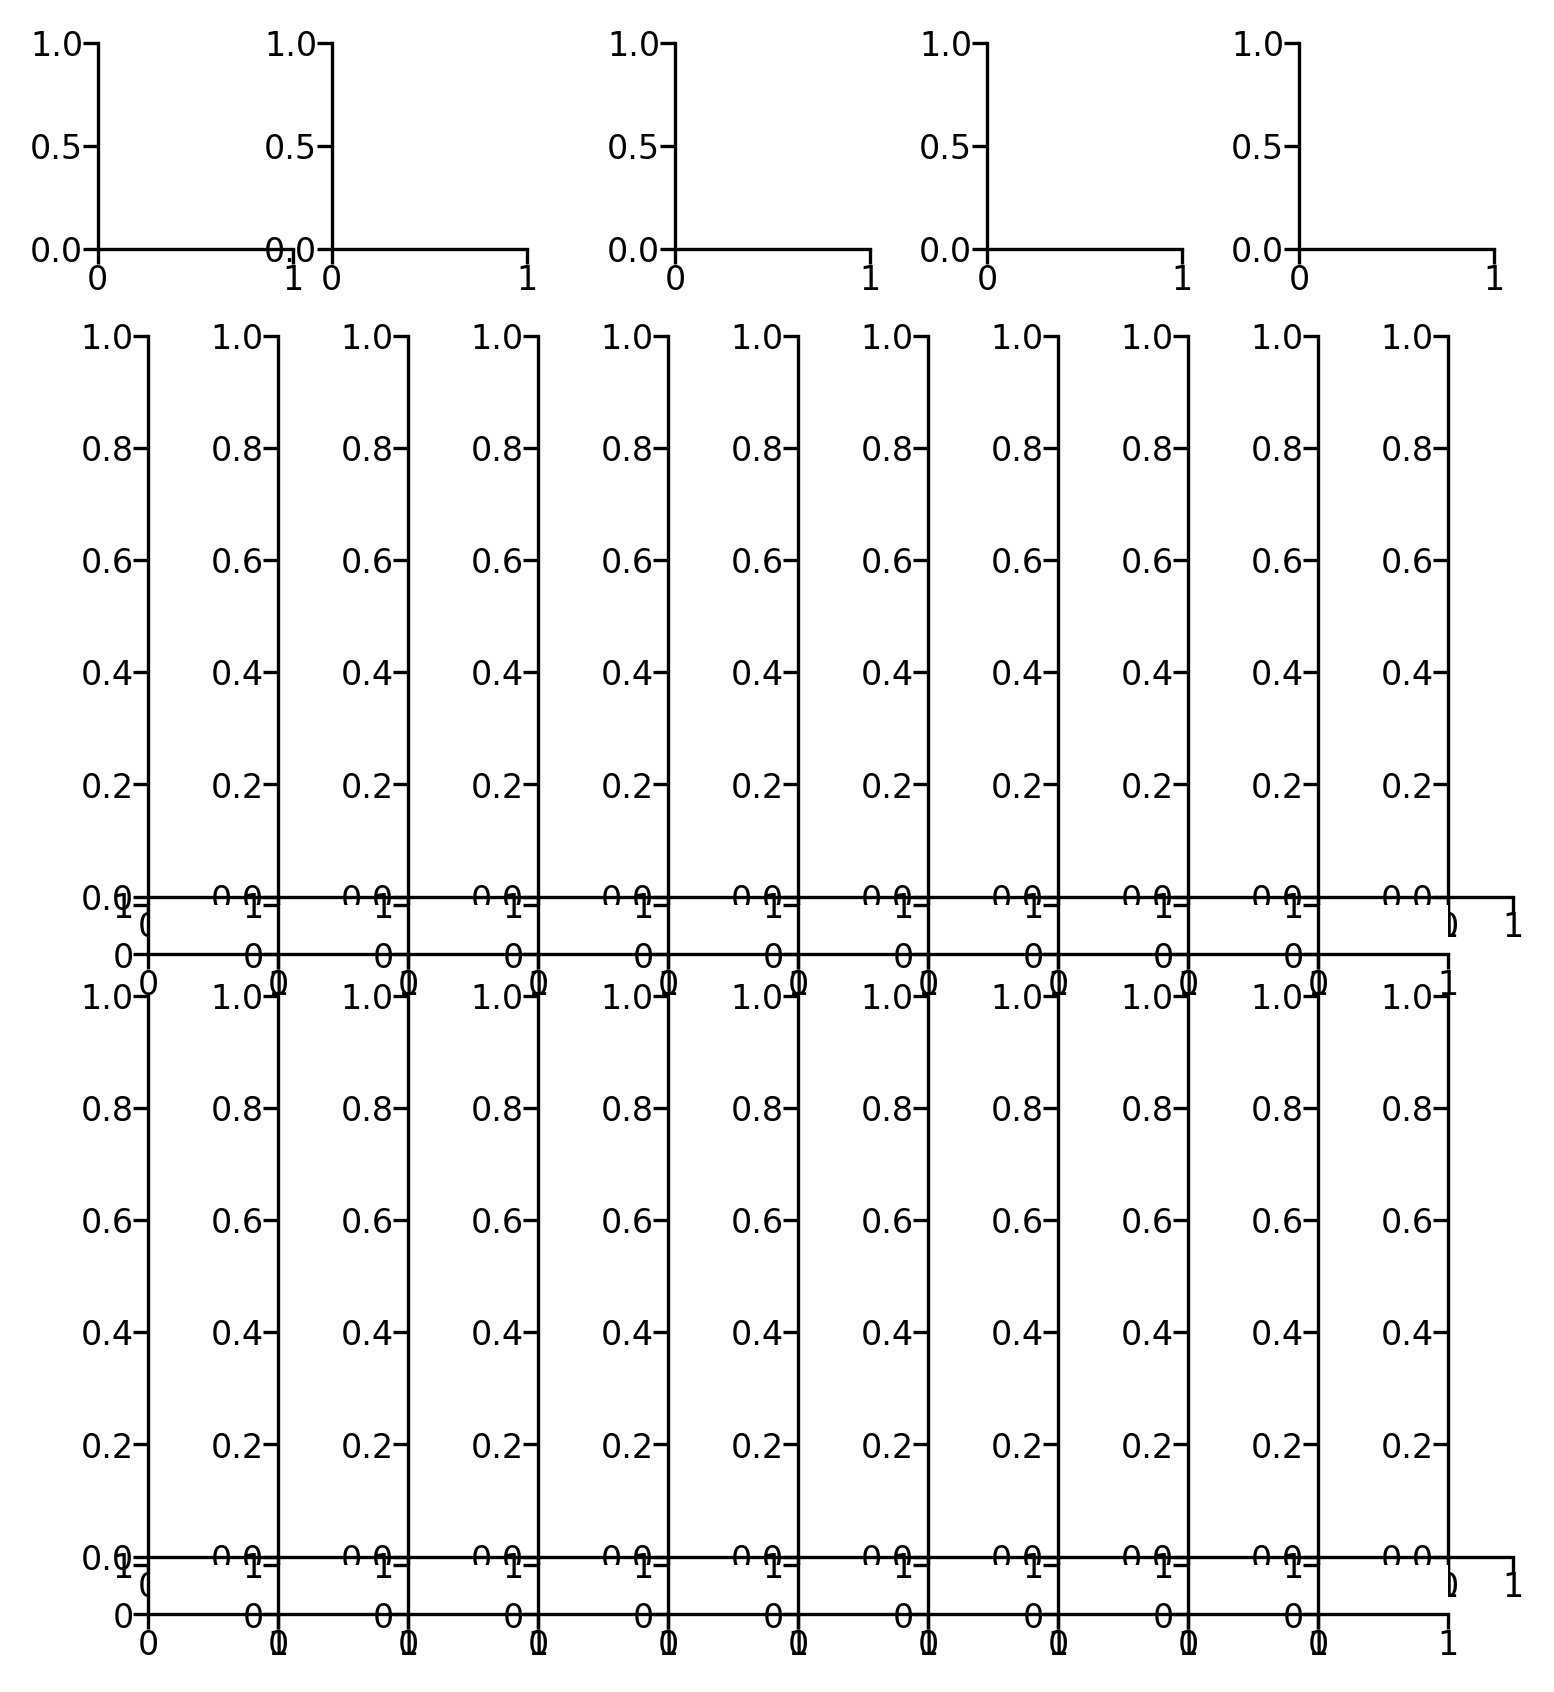

In [131]:
# Top small panels
ax_h1 = 1/5
ax_w1 = 1/5
hgap1 = 0.075
wgap1 = 0.075
train_xshift = 0.030
test_xshift = -0.020

# Raster plots
ax_h2 = 2/5
ax_w2 = 1/12  # 0.5/10.5 for 1d weights
hgap2 = 0.03
wgap2 = 0
ras_x_shift = 0.1

# Child plots in the raster plots
trace_h = 0.03
trace_hshift = 0.01
w1d_w = 0.5/12

fig = plt.figure()
ax_trainScheme = fig.add_axes([ax_w1 * 0 + wgap1/2 + train_xshift, 1 - ax_h1 * 1 + hgap1/2, ax_w1 - wgap1, ax_h1 - hgap1])
ax_testScheme = fig.add_axes([ax_w1 * 1 + wgap1/2 + test_xshift, 1 - ax_h1 * 1 + hgap1/2, ax_w1 - wgap1, ax_h1 - hgap1])
ax_acc = fig.add_axes([ax_w1 * 2 + wgap1/2, 1 - ax_h1 * 1 + hgap1/2, ax_w1 - wgap1, ax_h1 - hgap1])
ax_exW2D = fig.add_axes([ax_w1 * 3 + wgap1/2, 1 - ax_h1 * 1 + hgap1/2, ax_w1 - wgap1, ax_h1 - hgap1])
ax_inW2D = fig.add_axes([ax_w1 * 4 + wgap1/2, 1 - ax_h1 * 1 + hgap1/2, ax_w1 - wgap1, ax_h1 - hgap1])

ax_inRas180 = [fig.add_axes([ax_w2 * i + ras_x_shift, 1 - ax_h1 - ax_h2 * 1 + trace_h + hgap2/2, ax_w2, ax_h2 - hgap2 - trace_h]) for i in range(10)]
ax_exRas180 = [fig.add_axes([ax_w2 * i + ras_x_shift, 1 - ax_h1 - ax_h2 * 2 + trace_h + hgap2/2, ax_w2, ax_h2 - hgap2 - trace_h]) for i in range(10)]

ax_inRasW1d = fig.add_axes([ax_w2 * 10 + ras_x_shift, 1 - ax_h1 - ax_h2 * 1 + trace_h + hgap2/2, w1d_w, ax_h2 - hgap2 - trace_h])
ax_exRasW1d = fig.add_axes([ax_w2 * 10 + ras_x_shift, 1 - ax_h1 - ax_h2 * 2 + trace_h + hgap2/2, w1d_w, ax_h2 - hgap2 - trace_h])

ax_inRasTrace = [fig.add_axes([ax_w2 * i + ras_x_shift, 1 - ax_h1 - ax_h2 * 1 + trace_hshift, ax_w2, trace_h]) for i in range(10)]
ax_exRasTrace = [fig.add_axes([ax_w2 * i + ras_x_shift, 1 - ax_h1 - ax_h2 * 2 + trace_hshift, ax_w2, trace_h]) for i in range(10)]

ax_exinW2D = [ax_exW2D, ax_inW2D]
ax_exinRas = [ax_exRas180, ax_inRas180]
ax_exinRasTrace = [ax_exRasTrace, ax_inRasTrace]
ax_exinRasW1d = [ax_exRasW1d, ax_inRasW1d]



In [132]:
def plot_tempotron_traces(axRas, axTrace, axW1d, N, X, Y, Y_pred, temNw, all_nidx, yytun1d, kout_all, tspout_all, val2cmap, traj_deg, exintag):

    M = len(axRas)
    w_yax = np.arange(N)
    y_nidx = yytun1d[all_nidx[w_yax]]

    if exintag == 'in':

        ylim = (np.max(np.where(y_nidx <14.7)[0]), np.min(np.where(y_nidx > 25.8)[0]))
    else:
        ylim = (np.max(np.where(y_nidx <-24.8)[0]), np.min(np.where(y_nidx > -14.7)[0]))

    for Mi in range(M):

        ysep_NiList = []
        for Ni in range(N):
            tsp = X[Mi, Ni]
            axRas[Mi].eventplot(tsp, lineoffsets=Ni, linelengths=1, linewidths=1, color=val2cmap.to_rgba(temNw[Ni]))

            if (Ni % 20 ) == 0:
                axRas[Mi].axhline(Ni+0.5, linewidth=0.5, color='gray')
                ysep_NiList.append(Ni)

        ysep_ax = np.array(ysep_NiList) + 0.5
        axRas[Mi].set_xlim(0, 100)
        axRas[Mi].set_xticks([])
        axRas[Mi].set_yticks(ysep_ax)
        axRas[Mi].set_yticklabels(np.around(yytun1d[all_nidx[ysep_NiList]], 0).astype(int).astype(str))
        axRas[Mi].set_ylim(ylim[0], ylim[1])
        if Y[Mi]:
            axRas[Mi].set_facecolor('0.9')
            axTrace[Mi].set_facecolor('0.9')
        if Mi > 0:
            axRas[Mi].set_yticks([])

        # Plot voltage trace
        axTrace[Mi].plot(temN_tax, kout_all[Mi], color='gray')
        axTrace[Mi].eventplot(tspout_all[Mi], lineoffsets=2.2, linelengths=0.2, color='r')
        axTrace[Mi].set_xlim(0, 100)
        axTrace[Mi].set_xticks([0, 100])
        if exintag == 'ex':
            axTrace[Mi].set_xticklabels([100*Mi, 100*(Mi+1)])
        else:
            axTrace[Mi].set_xticklabels([])
        axTrace[Mi].set_ylim(0.1, 3)
        axTrace[Mi].axhline(Vthresh, color='k', linewidth=0.1)
        axTrace[Mi].set_yticks([])
        axTrace[Mi].spines.left.set_visible(False)
        if Mi > 0:
            axTrace[Mi].set_yticks([])

        # Plot flattened weights
        axW1d.barh(w_yax, temNw, color=val2cmap.to_rgba(temNw))
        axW1d.axvline(0, color='gray')
        axW1d.set_yticks(np.around(np.arange(N), 2))
        axW1d.axis('off')
        axW1d.set_ylim(ylim[0], ylim[1])


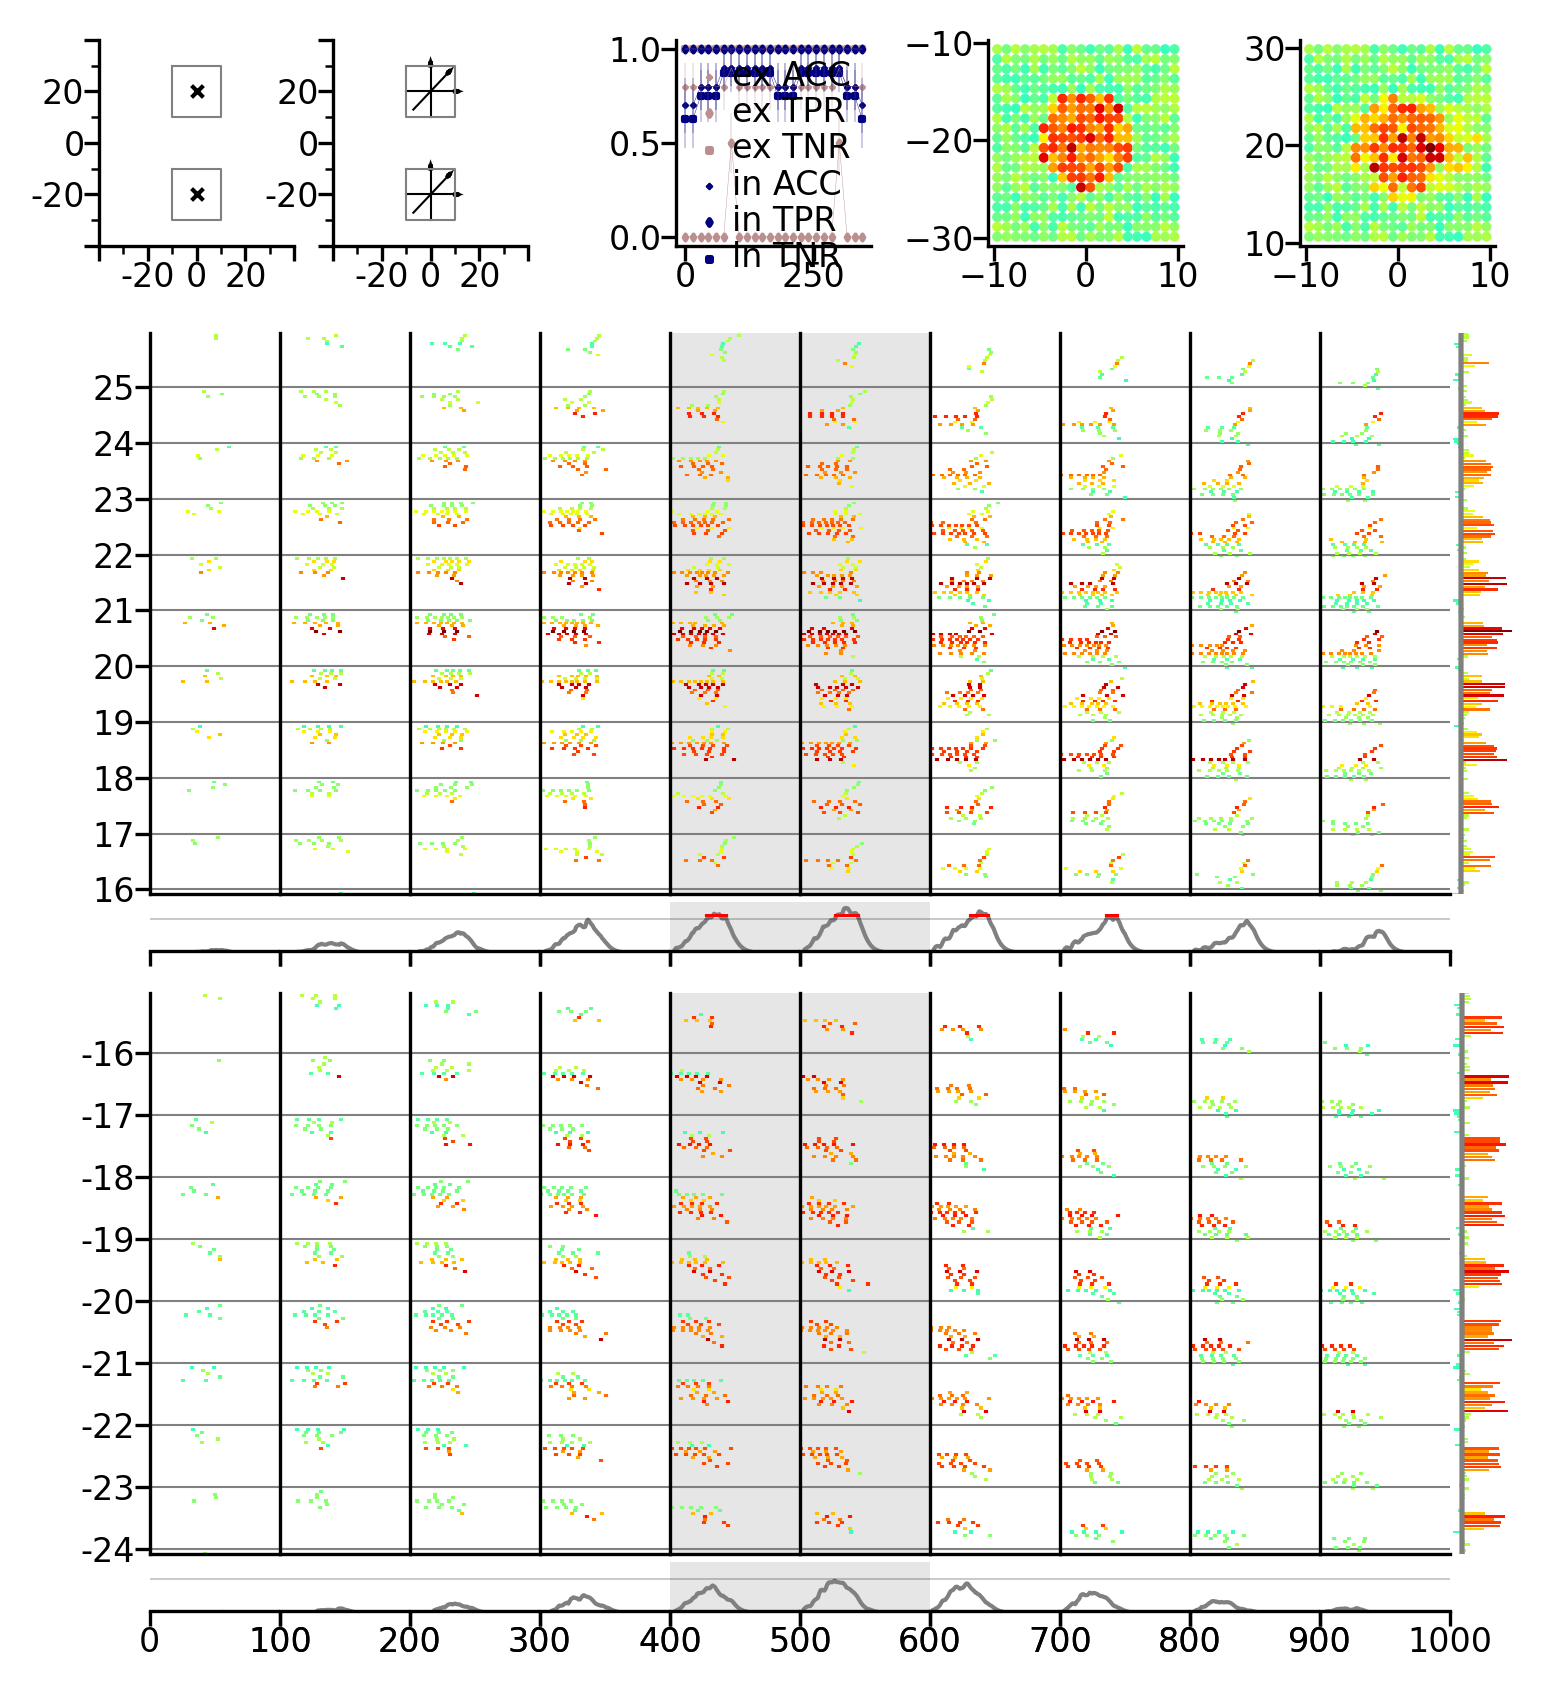

In [133]:
from library.visualization import customlegend
from library.script_wrappers import directional_acc_metrics

# # Determine weight color scale
all_temNw = np.concatenate( [np.load(join(data_dir, 'w_%s_ex.npy'%project_tag)), np.load(join(data_dir, 'w_%s_in.npy'%project_tag))] )
wmin, wmax = all_temNw.min(), all_temNw.max()
abswmax = max(np.abs(wmin), np.abs(wmax))
norm = mpl.colors.Normalize(vmin=-abswmax, vmax=abswmax)
val2cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)

# # Plot
for exin_i, exintag in enumerate(['ex', 'in']):

    # # Load and organize data
    dataset = load_pickle(join(data_dir, 'data_train_test_ori_%s_%s.pickle'%(project_tag, exintag)))
    temNw =  np.load(join(data_dir, 'w_%s_%s.npy'%(project_tag, exintag)))
    simdata = load_pickle(join(simdata_dir, 'fig6_%s.pkl'%(exintag)))

    X_test_ori = dataset['X_test_ori']
    Y_test_ori = dataset['Y_test_ori']
    trajtype_test_ori = dataset['trajtype_test_ori']
    X_train_ori = dataset['X_train_ori']
    Y_train_ori = dataset['Y_train_ori']
    trajtype_train_ori = dataset['trajtype_train_ori']
    theta_bounds = dataset['theta_bounds']
    all_nidx = dataset['all_nidx']

    N = len(X_train_ori[0])
    num_trajtypes = trajtype_test_ori.max()+1
    trajtype_ax = np.arange(num_trajtypes)
    a_ax = trajtype_ax/num_trajtypes*2*np.pi
    deg_ax = np.around(np.rad2deg(a_ax), 0).astype(int)

    BehDF = simdata['BehDF']
    NeuronDF = simdata['NeuronDF']
    xxtun1d = NeuronDF['neuronx'].to_numpy()
    yytun1d = NeuronDF['neurony'].to_numpy()
    aatun1d = NeuronDF['neurona'].to_numpy()

    # # Set up tempotron and run predictions
    Vthresh = 2
    temN_tax = np.arange(0, 100, 1)
    temN = Tempotron(N=N, lr=0.01, Vthresh=Vthresh, tau=5, tau_s=5/4, w_seed=0)
    temN.w = temNw
    Y_train_ori_pred, kout_train_ori, tspout_train_ori = temN.predict(X_train_ori, temN_tax)
    Y_test_ori_pred, kout_test_ori, tspout_test_ori = temN.predict(X_test_ori, temN_tax)

    # Plot Accuracies, PTR and PNR
    acc_color = 'rosybrown' if exintag == 'ex' else 'navy'
    val_test, se_test = directional_acc_metrics(Y_test_ori, Y_test_ori_pred, trajtype_test_ori, num_trajtypes=num_trajtypes)
    ax_acc.errorbar(x=deg_ax, y=val_test[0], yerr=se_test[0], color=acc_color, linewidth=0.1)
    ax_acc.errorbar(x=deg_ax, y=val_test[1], yerr=se_test[1], color=acc_color, linewidth=0.1)
    ax_acc.errorbar(x=deg_ax, y=val_test[2], yerr=se_test[2], color=acc_color, linewidth=0.1)
    ax_acc.scatter(x=deg_ax, y=val_test[0], label='%s ACC'%exintag, color=acc_color, marker='x', s=1)
    ax_acc.scatter(x=deg_ax, y=val_test[1], label='%s TPR'%exintag, color=acc_color, marker='d', s=1)
    ax_acc.scatter(x=deg_ax, y=val_test[2], label='%s TNR'%exintag, color=acc_color, marker='s', s=1)
    customlegend(ax_acc)


    # # Plot Weights
    ax_exinW2D[exin_i].scatter(xxtun1d[all_nidx], yytun1d[all_nidx], c=temNw, cmap=cm.jet, vmin=-abswmax, vmax=abswmax, s=2)


    # Plot 180 deg test traces for ex & in
    traj_deg = 180
    chosen_trajtype = trajtype_ax[deg_ax==traj_deg].squeeze()
    mask = trajtype_test_ori == chosen_trajtype
    X_test_chosen = X_test_ori[mask]
    Y_test_chosen = Y_test_ori[mask]
    Y_test_ori_pred_chosen = Y_test_ori_pred[mask]
    kout_test_chosen = kout_test_ori[mask]
    tspout_test_chosen = tspout_test_ori[mask]

    plot_tempotron_traces(ax_exinRas[exin_i], ax_exinRasTrace[exin_i], ax_exinRasW1d[exin_i], N,
                          X=X_test_chosen, Y=Y_test_chosen, Y_pred=Y_test_ori_pred_chosen, temNw=temNw,
                          all_nidx=all_nidx, yytun1d=yytun1d, kout_all=kout_test_chosen, tspout_all=tspout_test_chosen,
                          val2cmap=val2cmap, traj_deg=traj_deg, exintag=exintag)


# # Plot training and testing trajectories outside the loop
ax_trainScheme.scatter((0, 0), (20, -20), c='k', s=8, marker='x')
ax_testScheme.set_yticklabels([])
for trajrad in [0, np.pi/4, np.pi/2]:
    traj_vec = np.array([np.cos(trajrad), np.sin(trajrad)])
    start_pt = -10 * traj_vec
    end_pt = 10 * traj_vec
    for yoffset in [-20, 20]:
        ax_testScheme.plot((start_pt[0], end_pt[0]), (start_pt[1]+yoffset, end_pt[1]+yoffset), linewidth=0.5, color='k' )
        ax_testScheme.arrow(end_pt[0], end_pt[1]+yoffset, traj_vec[0], traj_vec[1], width=0.001, head_width=0.01, color='k', length_includes_head=True)
for ax_each in [ax_trainScheme, ax_testScheme]:
    ax_each.plot((-10, 10, 10, -10, -10), (30, 30, 10, 10, 30), linewidth=0.5, color='gray')   # In
    ax_each.plot((-10, 10, 10, -10, -10), (-10, -10, -30, -30, -10), linewidth=0.5, color='gray')   # Ex
    ax_each.set_xlim(-40, 40)
    ax_each.set_ylim(-40, 40)
    ax_each.set_xticks(np.arange(-40, 41, 20))
    ax_each.set_xticklabels(['', '-20', '0', '20', ''])
    ax_each.set_xticks(np.arange(-40, 41, 10), minor=True)
    ax_each.set_yticks(np.arange(-40, 41, 20))
    ax_each.set_yticklabels(['', '-20', '0', '20', ''])
    ax_each.set_yticks(np.arange(-40, 41, 10), minor=True)


fig.savefig(join(plot_dir, 'fig6.png'), dpi=300)
fig